# <span id="chap_concepts_paths"></span> Concepts: neighbourhoods and paths

The nodes and edges form the topology of a network. Going back to Euler's approach to [modelling the K&ouml;nigsberg bridges](introduction.ipynb#sec_konigsberg), it's easy to consider nodes to be "places" in some sense, and edges to be "routes" between them. This suggests that we can think of a network like we think of a map, in which we can "be at" a given "place" and "move to" an "adjacent" place by traversing a "route". This navigation analogy is so compelling that we'll use such terms even for networks that have no link to geography.

In this chapter we'll look at the notions of neighbourhoods and paths. Neighbourhoods are close-together sets of nodes, while paths provide one definition of what it means to be "far away". These are largely local properties of a small set of nodes but, as was the case with [degree](concepts-degree.ipynb), they give rise to global properties such as diameter. 

## <span id="concepts_paths_neighbourhoods"></span> Neighbourhoods

The edges of a network define **adjacency**. Adjacency is a very basic concept that can be generalised in several ways.

In [1]:
import networkx
import numpy

import cncp

import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import seaborn

/Users/sd/research/writing/complex-networks-complex-processes/notebook/cncp/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The most basic generalisation is to construct a **neighbourhood**, which is simply the set of all nodes that are adjacent to a chosen node. We might if we wanted to, generalise further and refer to this as the **1-neighbourhood**, with the **2-neighbourhood** being defined as all nodes adjacent to any node in the 1-neighbourhood, and so on. A neighbourhood (of whatever kind) gives us a notion of "closeness". We exclude the centre node itself from our definition of neighbourhood, but note that some people include it. 

We can use our [lattice network](concepts-networks.ipynb#sec_concepts_networks_lattice) to explore neighbourhoods. Starting from a simple lattice:

In [2]:
mesh = cncp.lattice_graph(10, 10)

We can explore the neighbourhoods of nodes. `networkx` will extract these directly:

In [3]:
ns = [ 0, 49, 64 ]                  # some nodes to sample

# compute the neighbourhoods of these nodes
neighbourhood = dict()
for n in ns:
    neighbourhood[n] = networkx.neighbors(mesh, n)
    print 'Neighbours of node {n}: {ns}'.format(n = n, ns = neighbourhood[n])

Neighbours of node 0: [1, 10]
Neighbours of node 49: [48, 59, 39]
Neighbours of node 64: [65, 74, 54, 63]


Of course it's hard to visualise which nodes we're talking about unless we know the node-naming scheme that `lattice_graph()` uses, so it might be better to draw the network and colour the neighbourhoods, with the centre nodes drawn slightly larger:

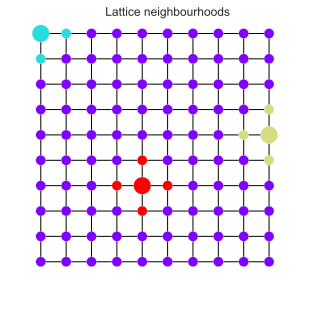

In [4]:
# colour map we'll use for the neighbourhoods
colour_map = plt.cm.rainbow

# set the node sizes, making the neighbourhood centres larger
sizes = [ 100 ] * mesh.order()
for n in ns:
    sizes[n] = 300

# create a colour table for the nodes according to neighbourhood
cols = [ 0 ] * mesh.order()
for i in range(len(ns)):
    n = ns[i]
    cols[n] = i + 1
    for m in neighbourhood[n]:
        cols[m] = i + 1
            
# draw the coloured lattice
fig = plt.figure(figsize = (5, 5))
plt.gca().set_axis_off()
plt.gca().set_xlim([-0.05, 1.05])
plt.gca().set_ylim([-0.05, 1.05])
cncp.draw_lattice(mesh, with_labels = False,
                  node_color = cols, cmap = colour_map, vmin = 0, vmax = len(ns),
                  node_size = sizes)
plt.title('Lattice neighbourhoods')

_ = plt.show()

By definition the size of a neighbourhood is the same as the [degree](concepts-degree.ipynb) of the centre node (at least for a [simple network](concepts-simple-network.ipynb)). The size of a 2-neighbourhood is more subtle, since there may be nodes that are adjacent to multiple nodes in the 1-neighbourhood. `networkx` doesn't provide a function to compute larger neighbourhoods directly, but we can easily write one:

In [5]:
def n_neighbourhood( g, c, s = 1 ):
    '''Generate the s-neighbourhood of a node c. By default s = 1, which generates
    the same set as networkx.neighbors().
    
    :param g: the network
    :param c: the centre point
    :param s: the size of neighbourhood (defaults to 1)
    :returns: the set of nodes in the s-neighbourhood of c'''
    if s <= 1:
        # base case, return the neighbours of the centre point
        return set(networkx.neighbors(g, c))
    else:
        # recursive case, union all the nodes in the (s-1)-neighbourhood
        # minus the centre point itself
        ns_minus_one = n_neighbourhood(g, c, s - 1)
        ns = ns_minus_one.copy()
        for n in ns_minus_one:
            ns |= set(networkx.neighbors(g, n))
        ns -= set( [ c ])
        return  ns

Note the use of sets to avoid duplication: in general there will be overlaps as neighbourhoods get bigger. Using the lattice example, the 2-neighbourhood of the centre point above is:

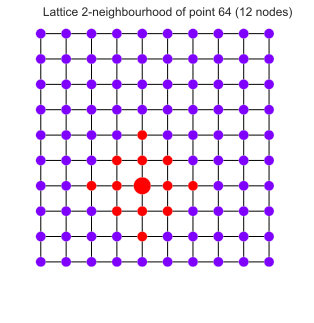

In [6]:
# node to focus on
i = 2
n = ns[i]

# compute the 2-neighbourhood
neighbourhood2 = n_neighbourhood(mesh, n, 2)

# sizes and colours as before
sizes = [ 100 ] * mesh.order()
sizes[n] = 300
cols = [ 0 ] * mesh.order()
cols[n] = i + 1
for m in neighbourhood2:
    cols[m] = i + 1
            
fig = plt.figure(figsize = (5, 5))
plt.gca().set_axis_off()
plt.gca().set_xlim([-0.05, 1.05])
plt.gca().set_ylim([-0.05, 1.05])
cncp.draw_lattice(mesh, with_labels = False,
                  node_color = cols, cmap = colour_map, vmin = 0, vmax = len(ns),
                  node_size = sizes)
plt.title('Lattice 2-neighbourhood of point {n} ({np} nodes)'.format(n = n, np = len(neighbourhood2)))

_ = plt.show()

## <span id="concepts_paths_paths"></span> Paths

Another generalisation of adjacency is to construct a sequence of nodes where each node in the sequence is adjacent to the one that precedes it. This is referred to s a **path**. If we label the nodes and edges in the network somehow, we can represent a path as the starting node, a list of edges, and the ending node: the intermediate nodes are all defined by the fact that an edge connects two nodes. The **length** of the path is the number of edges it contains. (Adjacencies are therefore just paths of length one.)

A path might be between two different nodes *A* and *B*, or might in some special cases be a sequence of nodes that begin and end at the same node *A*, or perhaps be a more complex *self-intersecting* path that connects *A* to *B* but intersects with *A* in the process

<img alt="Path types" src="concepts-paths.svg">

<center>
Different types of paths
</center>

In this figure, the simple path can be described as *A-a-b-c-B*, while the cycle is would be *A-a-b-d-A*, starting and finishing at node *A*. Both have length three. The self-intersecting path is a little more tricky. We could describe it as *A-a-b-d-e-f-b* (length 5), but we could equally go around the cycle twice to get a path *A-a-b-d-a-b-d-e-f-B* (of length 8), and so forth. (We could actually do the same thing for the cycle, constructign a cycle of length 6 as *A-a-b-d-a-b-d-A*.) The point is that, when we have cycles, we could "go around the cycle" as often as we want. By convention we usually choose the *shortest* path, going around any cycles only once, as the length of a self-intersecting path. 

### <span id="sec_concepts_paths_define_neighbourhoods"></span> Paths define neighbourhoods

The nodes in a node's [neighbourhood](#concepts_paths_neighbourhoods) are, by definition, those that are adjacent to it. We can re-phrase this as saying that a neighbourhood are all those nodes that can be reached by following a path of length one from the centre node. More generally, an $s$-neighbourhood is all the nodes reachable by paths of length $s$, excluding the centre node itself.

### <span id="sec_concepts_paths_directedness"></span> Directedness

In all the networksa we've considered so far, edges are **undirected** in the sense that one can traverse an edge in either direction. This is fine if edges represent a connection between two nodes that is in some sense symmetrical or bi-directional. If nodes represent people and edges represent the relationship "knows", then this is clearly the case: if *A* knows *B* then (presumably) *B* also knows *A*. It is sometimes useful to model relationships that are asymmetric, however: if edges represent "is an ancestor of", then one needs to know whether *A* is an ancestor of *B* or *vice versa*. The relationship represented by the edge is directional, and we capture this by saying that the edges are *directed*. We usually indicate this using an arrow pointing in the direction of the edge.

In terms of navigation, directed edges can only usually be traversed in the direction indicated by the arrow, respecting the direction of the edge. Directedness complicates navigation by forbidding some moves, and complicates the definition of connectedness through the possibility of having parts of the network that can reach all other parts while remaining unreachable themselves. We defer any consideration of directed networks until later.

## <span id="sec_concepts_paths_shortest"></span> Shortest paths

For any pair of nodes there will often be multiple paths between them, some longer and some shorter. The *shortest path* between two nodes is clearly of some significance: it's the "quickest route" between two points in the network. There may be several paths with the same length, in which case they would all be "shortest", but typically there is one that's shorter than the rest. By definition this path will not be self-intersecting, and is essentially the network equivalent of a "straight line" between the two end nodes.

We can illustrate the idea of shortest paths using the lattice again. `networkx` has a function that can compute the shortest path between any pair of nodes. Suppose we create a mesh again:

In [7]:
mesh = cncp.lattice_graph(10, 10)

We [know](concepts-networks.ipynb#sec_concepts_networks_lattice) that the lattice generator labels the nodes sequentially from left to right and top to bottom: the north-west and south-east corner nodes of this network are labelled 0 and 99 respectively. We can therefore ask what is the shortest path between these two nodes:

In [8]:
shortest = networkx.shortest_path(mesh, 0, 99)
print "Shortest path between the diagonal corners is {s}".format(s = shortest)

Shortest path between the diagonal corners is [0, 1, 2, 3, 4, 5, 6, 16, 17, 18, 28, 38, 48, 58, 68, 78, 88, 89, 99]


This function actually returns the *nodes* occurring on a path, rather than the *edges*, since `networkx` doesn't require us to label edges. This means that the length of the path is one less than the number of nodes in the list returned by `shortest_path()`. There is another `networkx` function, `shortest_path_length()`, that computes this directly:

In [9]:
print "Shortest path length is {l}".format(l = networkx.shortest_path_length(mesh, 0, 99))

Shortest path length is 18


A list of node labels isn't all that informative, but it's fairly easy to visualise this path by plotting the mesh and colouring the nodes on the path. To do this we use `matplotlib` to draw the mesh, but set the colours that'll be used for each node: 

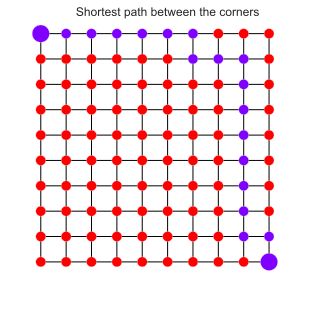

In [10]:
# set the colour for each node to be 0.25 or 0.75 depending on whether
# it is on the path or not
cols = [ 0.75 ] * mesh.order()
for i in shortest:
    cols[i] = 0.25
        
# set the node sizes, making the start and endpoints larger
sizes = [ 100 ] * mesh.order()
sizes[0] = sizes[-1] = 300

# colour map we'll use to show the path
colour_map = plt.cm.rainbow

# draw the mesh, colouring the nodes according to whether they're on the shortest path
fig = plt.figure(figsize = (5, 5))
ax1 = fig.gca()
_ = ax1.set_title("Shortest path between the corners")
_ = ax1.set_axis_off()
cncp.draw_lattice(mesh, ax = ax1, with_labels = False, node_size = sizes,
                  node_color = cols, cmap = colour_map)
_ = ax1.set_xlim([-0.05, 1.05])
_ = ax1.set_ylim([-0.05, 1.05])
_ = plt.show()

A moment's thought should convince you that, in this case, the path shown is only *one* of the shortest paths between the corners: there are others with the same length. If we want to know them all, `networkx` has a function `all_shortest_paths` that will find them all for us, returning a list of paths.

In many networks, the number of shortest paths will be small: often one path is uniquely shortest. However, in a regular network like a lattice, there are often a *lot* of shortest paths: 

In [11]:
all_shortest = networkx.all_shortest_paths(mesh, 0, 99)
print 'Number of shortest paths between corners: {n}'.format(n = len(list(all_shortest)))

Number of shortest paths between corners: 48620


You might be thinking that there is some relationship between all these paths, for example that more of them pass through some nodes than others &ndash; and you would be right, and this is a notion that leads to the idea of node (and edge) centrality, which we'll return to later.

## <span id="sec_concepts_paths_diameter"></span> Network diameter

The length of the shortest path is a local property to the pair of nodes involved. There is a global property here as well, though. If we compute the shortest paths between *all* pairs of nodes, then some of these paths will clearly be longer than others. The *longest shortest path* will therefore be the farthest distance (in terms of path length) between *any pair* of nodes in the network, and this is value is referred to as the **diameter** of the network. You can think of the diameter as the "longest straight line" between any two nodes in the network. `networkx` can calculate the diameter for us immediately:

In [12]:
print "Diameter of the mesh is {d}".format(d = networkx.diameter(mesh))

Diameter of the mesh is 18


Unsurprisingly, the longest "straight line" in the mesh network is the "line" between the two corners, which we explored above. The diameter isn't the longest path, or even the longest simple path: the path "all round the edges" is longer than the diameter, as are meandering and semi-reversing paths. But the diameter measures the longest "irreducuble" path between two points, and so is a measure of the "width" of the network: hence it's name.